In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import gc
import numpy as np
import os
import sys
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
from tqdm import tqdm

In [37]:
from pathlib import Path
rootpath = Path.cwd().parent
sys.path.append(os.path.join(rootpath))

In [38]:
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, 
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.eda_helpers import (
    plot_missing_proportion_barchart, get_cols, single_col_target_check, plot_scatterplot
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, BINARY_COLUMNS, ROUND_COLUMNS,
    MEAN_FEATURES, MIN_FEATURES, MAX_FEATURES, LAST_FEATURES
)

In [39]:
RAW_DATA_PATH = "../raw_data"
PROCESSED_DATA_PATH = "../processed_data"

In [40]:
RAW_TRAIN_PARQUET_PATH = os.path.join(RAW_DATA_PATH, "train_parquet")
RAW_TRAIN_PICKLE_PATH = os.path.join(RAW_DATA_PATH, "train_pickle")
RAW_TEST_PARQUET_PATH = os.path.join(RAW_DATA_PATH, "test_parquet")
RAW_TEST_PICKLE_PATH = os.path.join(RAW_DATA_PATH, "test_pickle")

In [41]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Read Data

In [9]:
train = read_file(f"{RAW_TRAIN_PICKLE_PATH}/train_data.pkl")
test = read_file(f"{RAW_TEST_PICKLE_PATH}/test_data.pkl")

Shape of data: (5531451, 193)
Shape of data: (11363762, 192)


### Feature Data Type

In [46]:
column_types = dict(
    id_col = get_cols(train, "customer"),
    target_col = get_cols(train, "target"),
    payment_vars = get_cols(train, "P", first=True),
    spend_vars = get_cols(train, "S", first=True),
    risk_vars = get_cols(train, "R", first=True),
    balance_vars = get_cols(train, "B", first=True),
    delinquency_vars = get_cols(train, "D", first=True)
)

In [47]:
for col in column_types:
    print(col, len(column_types[col]))

id_col 1
target_col 1
payment_vars 3
spend_vars 22
risk_vars 28
balance_vars 40
delinquency_vars 96


### Missing value analysis (Pre Imputation)

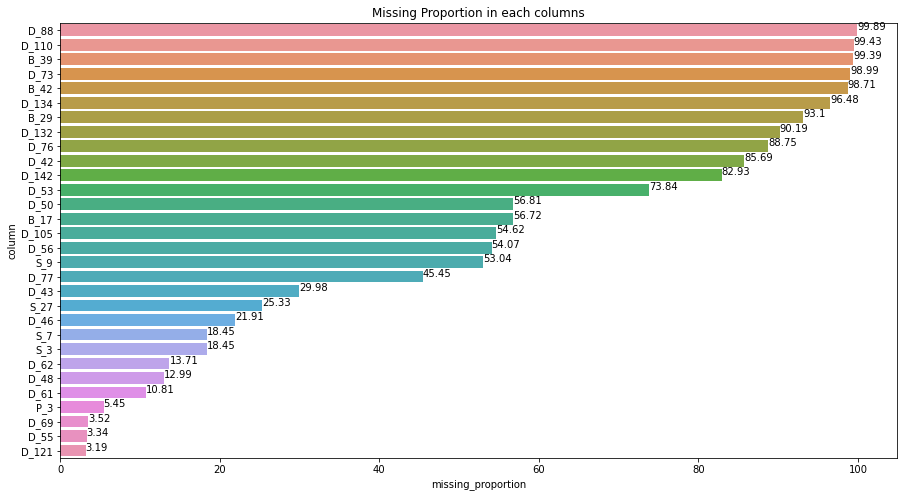

In [10]:
train_missing_prop_df = plot_missing_proportion_barchart(train)

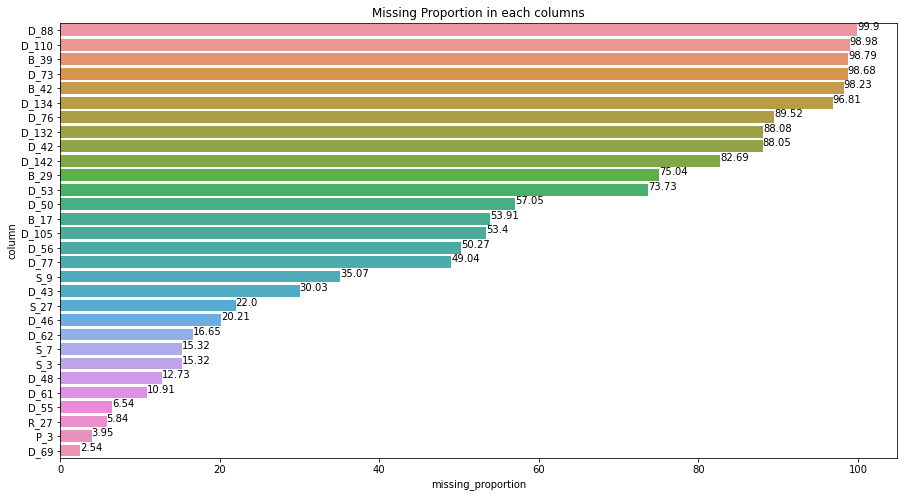

In [11]:
test_missing_prop_df = plot_missing_proportion_barchart(test)

In [12]:
train_missing_prop_df = train_missing_prop_df.set_index("column")
train_missing_prop_df.columns = ["train_missing_proportion"]

In [13]:
test_missing_prop_df = test_missing_prop_df.set_index("column")
test_missing_prop_df.columns = ["test_missing_proportion"]

In [18]:
missing_proportion_df = train_missing_prop_df.merge(
    test_missing_prop_df, 
    left_index=True, 
    right_index=True, 
    how="outer"
)

In [20]:
missing_proportion_df["abs_difference"] = (
    missing_proportion_df["train_missing_proportion"] - missing_proportion_df["test_missing_proportion"]
).abs()

In [24]:
missing_proportion_df.loc[missing_proportion_df["abs_difference"] > 3]

,train_missing_proportion,test_missing_proportion,abs_difference
column,,,
B_29,93.104594,75.038205,18.066389
D_55,3.340950,6.538090,3.197140
D_56,54.071581,50.271275,3.800306
D_77,45.447605,49.040318,3.592713
R_27,2.326749,5.838771,3.512021
S_27,25.326718,22.002177,3.324541
S_3,18.449843,15.320323,3.129520
S_7,18.449843,15.320323,3.129520
S_9,53.035686,35.070903,17.964783


In [25]:
train["target"].mean()

0.24909720794778803

### B_29

5150035 null count, 0.931 null proportion
0.2512 of the targets have label = 1


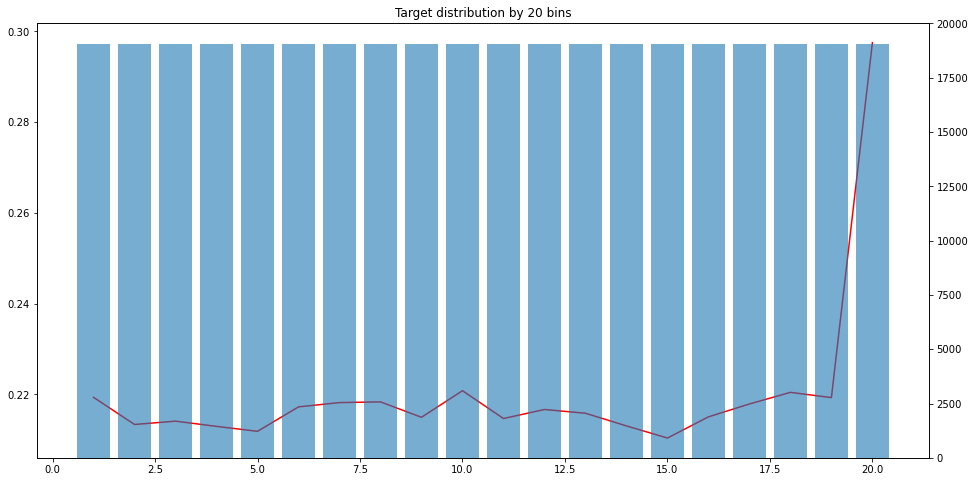

In [42]:
tmp_df = single_col_target_check(train, "B_29")

### S_9

2933643 null count, 0.530 null proportion
0.2719 of the targets have label = 1


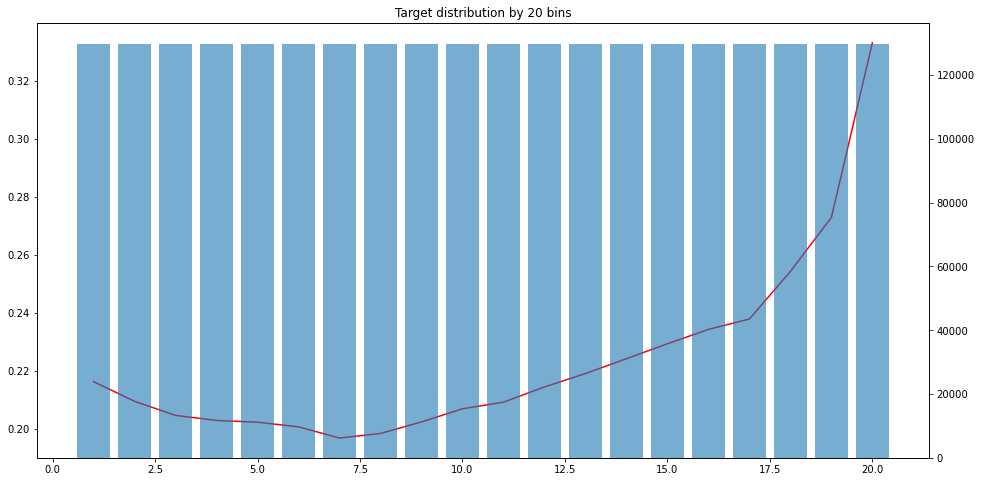

In [43]:
tmp_df = single_col_target_check(train, "S_9")

## EDA